In [1]:
import pandas as pd
import censusdis.data as ced
import censusdis.maps as cem
from censusdis.states import IL
from censusdis.counties.illinois import COOK

from pathlib import Path

import divintseg as dis
import geopandas as gpd

import contextily as cx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pathlib import Path
import imageio.v3 as iio
import folium
import branca.colormap as cm
import numpy as np

import warnings
# Suppress FutureWarnings from divintseg
warnings.simplefilter(action='ignore', category=FutureWarning)

## Setup

First, let's set up some constants needed to interact with the U.S. census API via `censusdis`. The main features we are interested in are tract-level populations of single racial groups or two or more racial groups. These features are available in the decennial waves of the [Public Law 94-171 Redistricting Data](https://www.census.gov/programs-surveys/decennial-census/about/rdo/summary-files.html), which has collected these features since 1980. See the city of Chicago data portal [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik) for the list of census tracts on the Near North Side.

In [2]:
CENSUS_API_KEY = None
DATASET = "dec/pl"
GROUP = "P1"

# Census tracts consist of a 4 digit identifier within county, and then an optional 2 digit suffix
tracts_near_north = [
    '080100',
    '080201',
    '080202',
    '080300',
    '080400',
    '842200',
    '081000',
    '081100',
    '081201',
    '081202',
    '081300',
    '081401',
    '081402',
    '081403',
    '081500',
    '081600',
    '081700',
    '081800',
    '081900',
    '838300',
]

## Download the data for Near North

This section downloads, renames, and cleans the census data via the `censusdis` module. The final output is a stacked dataset at the tract level containing population by race and diversity and integration features calculated by the `divintseg` module.

"Diversity" and "integration" are calculated at the tract level using the Gini-Simpson index. Mathematically, these quantities are:

$D_t = \sum_{g} p_{g,t}(1 - p_{g,t})$

$I_t = \sum_b r_{b,t} D_b$

$D_b = \sum_{g} p_{g,b}(1 - p_{g, b})$

where $D_t$ is diversity at the tract level, $g$, $t$, and $b$ index race groupings, tract, and block, respectively, $p_{g,t}$ is the proportion of the population belonging to group $g$ in tract $t$, and $r_{b,t}$ is the proportion of the population in block $b$ living in tract $t$. $D_b$ represents block-level diversity and is calculated similar to $D_t$. See the documentation for `divintseg` [here](https://github.com/censusdis/divintseg) for more details.

In [3]:
df_stacked = pd.DataFrame()
download_vars_2010 = [
    'P001003',
    'P001004',
    'P001005',
    'P001006',
    'P001007',
    'P001008',
    'P001009'
]

rename_dict_2010 = {
    'P001003': 'race_white',
    'P001004': 'race_black',
    'P001005': 'race_native_american',
    'P001006': 'race_asian',
    'P001007': 'race_hawaiian_pi',
    'P001008': 'race_other',
    'P001009': 'race_two_or_more'
}

download_vars_2020 = [
    'P1_003N',
    'P1_004N',
    'P1_005N',
    'P1_006N',
    'P1_007N',
    'P1_008N',
    'P1_009N'
]

rename_dict_2020 = {
    'P1_003N': 'race_white',
    'P1_004N': 'race_black',
    'P1_005N': 'race_native_american',
    'P1_006N': 'race_asian',
    'P1_007N': 'race_hawaiian_pi',
    'P1_008N': 'race_other',
    'P1_009N': 'race_two_or_more'
}

rename_dict = {
    2010: rename_dict_2010,
    2020: rename_dict_2020
}

download_vars = {
    2010: download_vars_2010,
    2020: download_vars_2020
}

for year in [2010, 2020]:
    vars_to_keep = download_vars[year]

    df_near_north = ced.download(
        dataset=DATASET,
        vintage=year,
        # leaves_of_group=GROUP,
        download_variables=download_vars[year],
        state=IL,
        county=COOK,
        tract=tracts_near_north,
        block='*',
        api_key=CENSUS_API_KEY,
    )

    df_near_north = df_near_north.rename(columns=rename_dict[year])

    # Collapse to the tract level
    race_cols = [col for col in df_near_north.columns if col.startswith('race_')]
    df_near_north_tract = df_near_north.pivot_table(
        index=['TRACT'],
        values=race_cols,
        aggfunc='sum'
    ).reset_index()

    # Calculate total pop and % race based on the race columns, not census columns
    df_near_north_tract['pop_total_race'] = df_near_north_tract.filter(like='race').sum(axis=1)
    df_near_north_tract[[f'{c}_pct' for c in race_cols]] = df_near_north_tract[
        race_cols
    ].div(df_near_north_tract['pop_total_race'], axis=0)

    df_near_north_final = dis.di(
        df_communities=df_near_north,
        by=['STATE', 'COUNTY', 'TRACT'], 
        over='BLOCK'
    ).reset_index().merge(
        df_near_north_tract,
        on='TRACT',
        how='left'
    )

    df_near_north_final['year'] = year
    df_stacked = pd.concat([df_stacked, df_near_north_final]) 

This bit of code adds polygons to the stacked data.

In [4]:
df_stacked = ced.add_inferred_geography(df_stacked, 2020)
df_stacked.head(10)

,STATE,COUNTY,TRACT,diversity,integration,race_asian,race_black,race_hawaiian_pi,race_native_american,race_other,...,pop_total_race,race_white_pct,race_black_pct,race_native_american_pct,race_asian_pct,race_hawaiian_pi_pct,race_other_pct,race_two_or_more_pct,year,geometry
0,17,031,080100,0.176103,0.172607,275,150,0,4,47,...,6013,0.906037,0.024946,0.000665,0.045734,0.000000,0.007816,0.014801,2010,"POLYGON ((-87.62889 41.91122, -87.62573 41.911..."
1,17,031,080201,0.196036,0.193356,144,109,0,2,39,...,3287,0.894737,0.033161,0.000608,0.043809,0.000000,0.011865,0.015820,2010,"POLYGON ((-87.63323 41.91116, -87.63308 41.911..."
2,17,031,080202,0.203878,0.200772,215,79,0,4,29,...,3498,0.889651,0.022584,0.001144,0.061464,0.000000,0.008290,0.016867,2010,"POLYGON ((-87.63312 41.9077, -87.63157 41.9078..."
3,17,031,080300,0.297783,0.278195,327,266,2,5,39,...,4315,0.831981,0.061645,0.001159,0.075782,0.000463,0.009038,0.019930,2010,"POLYGON ((-87.63859 41.91112, -87.63762 41.911..."
4,17,031,080400,0.517231,0.225308,94,2568,1,4,29,...,4317,0.357887,0.594858,0.000927,0.021774,0.000232,0.006718,0.017605,2010,"POLYGON ((-87.64343 41.91102, -87.64306 41.911..."
5,17,031,081000,0.411195,0.369717,684,925,2,11,105,...,7546,0.751657,0.122582,0.001458,0.090644,0.000265,0.013915,0.019481,2010,"POLYGON ((-87.63448 41.90385, -87.633 41.90388..."
6,17,031,081100,0.419019,0.344908,337,466,4,6,49,...,3640,0.745330,0.128022,0.001648,0.092582,0.001099,0.013462,0.017857,2010,"POLYGON ((-87.62999 41.90392, -87.62868 41.903..."
7,17,031,081201,0.280625,0.273287,318,175,1,2,59,...,4059,0.843065,0.043114,0.000493,0.078344,0.000246,0.014536,0.020202,2010,"POLYGON ((-87.62834 41.90156, -87.6272 41.9015..."
8,17,031,081202,0.176519,0.172100,135,74,0,4,25,...,2995,0.905843,0.024708,0.001336,0.045075,0.000000,0.008347,0.014691,2010,"POLYGON ((-87.62868 41.90394, -87.62798 41.903..."
9,17,031,081300,0.280341,0.272919,485,179,0,2,30,...,4884,0.841523,0.036650,0.000410,0.099304,0.000000,0.006143,0.015971,2010,"POLYGON ((-87.6241 41.89839, -87.62413 41.8992..."


## Wrangle 2000 separately

The census API does not have redistricting data for the decennial 2000 census. As a result, I manually downloaded the decennial census data and associated shapefiles from IPUMS NHGIS [here](https://www.nhgis.org/). Census tracts in 2000 are slightly different than 2010 and 2020; the full list can be found [here](https://www.chicago.gov/content/dam/city/depts/zlup/Zoning_Main_Page/Publications/Census_2000_Community_Area_Profiles/PDF_08.pdf) from the City of Chicago.

In [5]:
df_near_north_2000 = pd.read_csv(Path(Path.cwd() / 'data' / 'census_2000.csv'), low_memory=False)

tracts_near_north_2000 = [t for t in range(80100, 82000, 100)] + [80201]

df_near_north_2000 = df_near_north_2000.query(
    'TRACTA in @tracts_near_north_2000'
)

df_near_north_2000 = df_near_north_2000[
    [
        'STATEA',
        'COUNTYA',
        'TRACTA',
        'BLOCKA',
        'FYE001',
        'FYE002',
        'FYE003',
        'FYE004',
        'FYE005',
        'FYE006',
        'FYE007',
        'GISJOIN'
    ]
]

This chunk of code below performs the same cleaning and wrangling steps as for 2010 and 2020.

In [6]:
# Wrangle to stack with the other data
rename_dict_2000 = {
    'STATEA': 'STATE',
    'COUNTYA': 'COUNTY',
    'TRACTA': 'TRACT',
    'BLOCKA': 'BLOCK',
    'FYE001': 'race_white',
    'FYE002': 'race_black',
    'FYE003': 'race_native_american',
    'FYE004': 'race_asian',
    'FYE005': 'race_hawaiian_pi',
    'FYE006': 'race_other',
    'FYE007': 'race_two_or_more'
}

df_near_north_2000 = df_near_north_2000.rename(columns=rename_dict_2000)

df_near_north_2000['COUNTY'] = df_near_north_2000['COUNTY'].astype(int)

df_near_north_2000['STATE'] = df_near_north_2000['STATE'].apply(lambda x: f"{x:02}")
df_near_north_2000['COUNTY'] = df_near_north_2000['COUNTY'].apply(lambda x: f"{x:03}")
df_near_north_2000['TRACT'] = df_near_north_2000['TRACT'].apply(lambda x: f"{x:06}")

# Trim GISJOIN column of the final 4 numbers, which is block
df_near_north_2000['GISJOIN'] = df_near_north_2000['GISJOIN'].str[:-4]

# Collapse to the tract level
df_near_north_2000_tract = df_near_north_2000.pivot_table(
    index=['TRACT'],
    values=race_cols,
    aggfunc='sum'
).reset_index()

# Calculate total pop and % race based on the race columns, not census columns
df_near_north_2000_tract['pop_total_race'] = df_near_north_2000_tract.filter(like='race').sum(axis=1)
df_near_north_2000_tract[[f'{c}_pct' for c in race_cols]] = df_near_north_2000_tract[
    race_cols
].div(df_near_north_2000_tract['pop_total_race'], axis=0)

df_near_north_2000_final = dis.di(
    df_communities=df_near_north_2000,
    by=['STATE', 'COUNTY', 'TRACT'], 
    over='BLOCK'
).reset_index().merge(
    df_near_north_2000[['TRACT', 'GISJOIN']],
    on=['TRACT'],
    how='left'
).drop_duplicates(
    subset='TRACT',
    keep='first'
).merge(
    df_near_north_2000_tract,
    on='TRACT',
    how='left'
).reset_index()

df_near_north_2000_final['year'] = 2000

A wrinkle is that we need to manually add the shapefiles from 2000.

In [7]:
# Add census shapefiles
census_2000_shp = gpd.read_file('zip://data/census_2000/shapefiles.zip/US_tract_2000.shp')
census_2000_shp = census_2000_shp[['GISJOIN', 'geometry']]
census_2000_shp.head(10)

census_2000_shp = census_2000_shp.to_crs('EPSG:4269')

In [8]:
df_near_north_2000_final = df_near_north_2000_final.merge(
    census_2000_shp,
    on=['GISJOIN'],
    how='left'
)

df_near_north_2000_final.head(10)
df_near_north_2000_final = df_near_north_2000_final.drop(columns=['GISJOIN'])

In [9]:
df_near_north_2000_final.head(10)

,index,STATE,COUNTY,TRACT,diversity,integration,race_asian,race_black,race_hawaiian_pi,race_native_american,...,pop_total_race,race_white_pct,race_black_pct,race_native_american_pct,race_asian_pct,race_hawaiian_pi_pct,race_other_pct,race_two_or_more_pct,year,geometry
0,0,17,031,080100,0.135256,0.133233,201,164,1,8,...,6895,0.929079,0.023785,0.001160,0.029152,0.000145,0.008557,0.008122,2000,"POLYGON ((-87.62405 41.90423, -87.62476 41.904..."
1,1,17,031,080200,0.207206,0.205483,338,304,2,6,...,7205,0.887994,0.042193,0.000833,0.046912,0.000278,0.006384,0.015406,2000,"POLYGON ((-87.62865 41.90403, -87.63005 41.904..."
2,2,17,031,080300,0.334618,0.310560,187,428,1,5,...,4097,0.807176,0.104467,0.001220,0.045643,0.000244,0.020503,0.020747,2000,"POLYGON ((-87.63305 41.90393, -87.63458 41.903..."
3,3,17,031,080400,0.402846,0.219108,62,3332,2,4,...,4492,0.215272,0.741763,0.000890,0.013802,0.000445,0.010686,0.017142,2000,"POLYGON ((-87.63855 41.90383, -87.63925 41.903..."
4,4,17,031,080500,0.087736,0.063902,7,2454,0,3,...,2571,0.034228,0.954492,0.001167,0.002723,0.000000,0.003112,0.004278,2000,"POLYGON ((-87.64335 41.91073, -87.64335 41.910..."
5,5,17,031,080600,0.593747,0.396607,3,59,0,0,...,183,0.540984,0.322404,0.000000,0.016393,0.000000,0.092896,0.027322,2000,"POLYGON ((-87.64845 41.90853, -87.64845 41.907..."
6,6,17,031,080700,0.549346,0.147783,0,11,0,0,...,29,0.551724,0.379310,0.000000,0.000000,0.000000,0.034483,0.034483,2000,"POLYGON ((-87.64315 41.90053, -87.64315 41.899..."
7,7,17,031,080800,0.035592,0.035000,0,1688,0,2,...,1719,0.011635,0.981966,0.001163,0.000000,0.000000,0.002327,0.002909,2000,"POLYGON ((-87.63745 41.89893, -87.63795 41.898..."
8,8,17,031,080900,0.602725,0.591100,45,300,6,0,...,746,0.479893,0.402145,0.000000,0.060322,0.008043,0.012064,0.037534,2000,"POLYGON ((-87.63445 41.90053, -87.63442 41.899..."
9,9,17,031,081000,0.404648,0.360712,499,991,11,12,...,7330,0.756071,0.135198,0.001637,0.068076,0.001501,0.012142,0.025375,2000,"POLYGON ((-87.62995 41.89663, -87.63135 41.896..."


We also need to convert to a `geopandas` dataframe.

In [10]:
df_near_north_2000_final_crs = gpd.GeoDataFrame(
    df_near_north_2000_final, 
    geometry='geometry'
)

df_stacked = pd.concat([df_stacked, df_near_north_2000_final_crs]).sort_values(by='year')

## Compute diversity and integration

Finally, we get to plotting. The chunks below plot our calculated diversity and integration metrics over the census tracts, as well as the proportion of the black population.

In [11]:
path_assets = Path('_assets/')
path_assets.mkdir(parents=True, exist_ok=True)

## Diversity

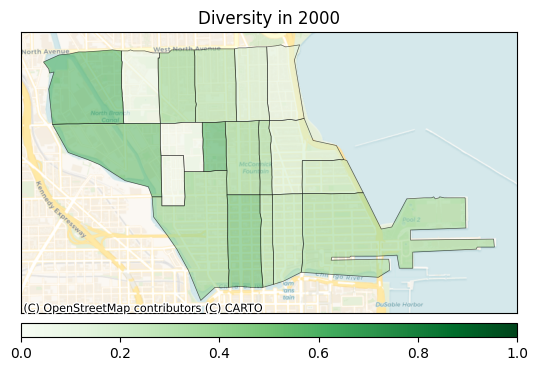

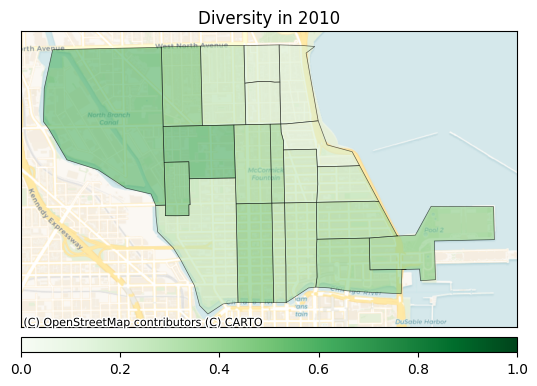

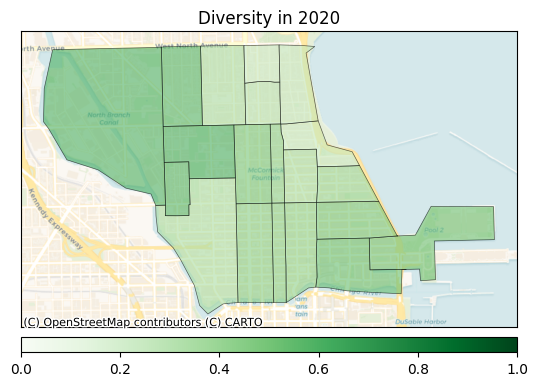

In [12]:
path_diversity = Path('_assets/diversity/')
path_diversity.mkdir(parents=True, exist_ok=True)

for year in [2000, 2010, 2020]:
    df_to_plot = df_stacked[df_stacked['year'] == year]
    df_to_plot = df_to_plot.to_crs(epsg=3857) # needed to work with cx

    # Plot ----
    fig, ax = plt.subplots(1, 1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)

    plot_diversity = df_to_plot.plot(
        column='diversity',
        ax=ax,
        edgecolor='black',
        alpha=0.6,
        linewidth=0.5,
        cmap='Greens',
        legend=True,
        cax=cax,
        vmin=0.0,
        vmax=1.0,
        legend_kwds={
            "orientation": "horizontal"
        },
    )

    title = "Diversity in " + str(year)
    ax.set_title(title)
    # Remove tick labels and ticks
    plot_diversity.set_xticks([])
    plot_diversity.set_yticks([])
    plot_diversity.set_xticklabels([])
    plot_diversity.set_yticklabels([])

    # Keep the frame (border)
    for spine in plot_diversity.spines.values():
        spine.set_visible(True)
    cx.add_basemap(plot_diversity, source=cx.providers.CartoDB.Voyager)

    # Save in assets
    filename = f'_assets/diversity/plot_diversity_{year}.png'
    plt.savefig(filename, bbox_inches = 'tight')

## Integration

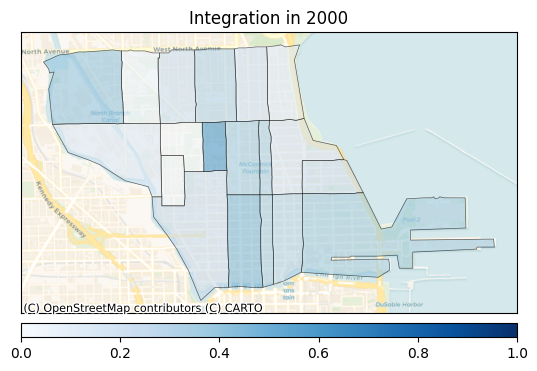

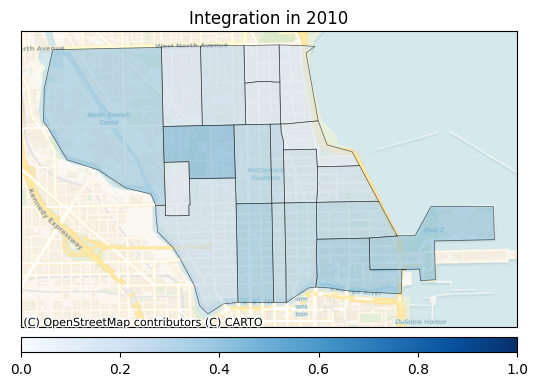

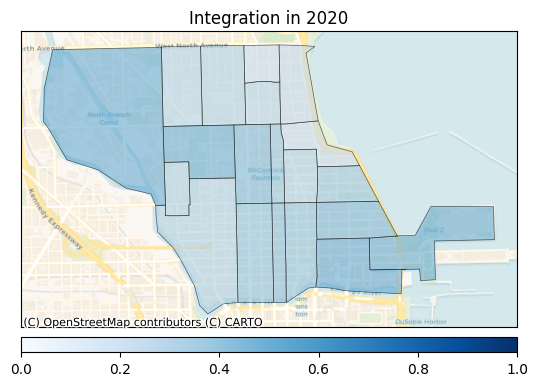

In [13]:
path_integration = Path('_assets/integration/')
path_integration.mkdir(parents=True, exist_ok=True)

for year in [2000, 2010, 2020]:
    df_to_plot = df_stacked[df_stacked['year'] == year]
    df_to_plot = df_to_plot.to_crs(epsg=3857) # needed to work with cx

    # Plot ----
    fig, ax = plt.subplots(1, 1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    
    plot_integration = df_to_plot.plot(
        column='integration',
        ax=ax,
        edgecolor='black',
        alpha=0.6,
        linewidth=0.5,
        cmap='Blues',
        legend=True,
        cax=cax,
        vmin=0.0,
        vmax=1.0,
        legend_kwds={
            "orientation": "horizontal"
        },
    )

    title = "Integration in " + str(year)
    ax.set_title(title)
    # Remove tick labels and ticks
    plot_integration.set_xticks([])
    plot_integration.set_yticks([])
    plot_integration.set_xticklabels([])
    plot_integration.set_yticklabels([])

    # Keep the frame (border)
    for spine in plot_integration.spines.values():
        spine.set_visible(True)
    cx.add_basemap(plot_integration, source=cx.providers.CartoDB.Voyager)

    # Save in assets
    filename = f'_assets/integration/plot_integration_{year}.png'
    plt.savefig(filename, bbox_inches = 'tight')

## Percent Black

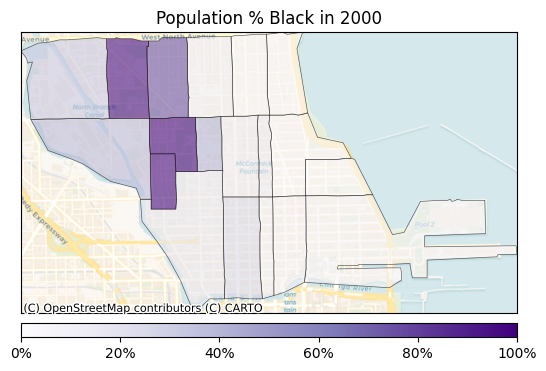

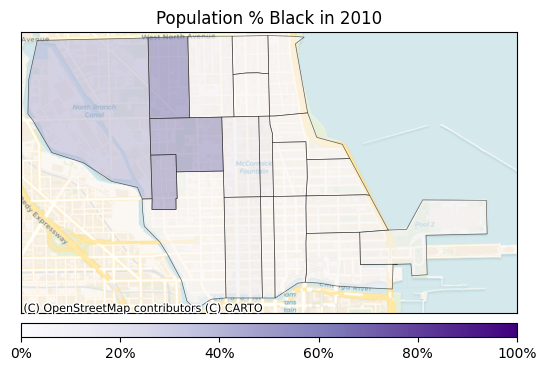

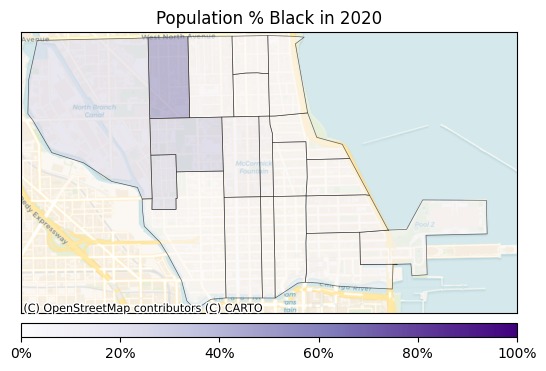

In [15]:
path_pct_black = Path('_assets/pct_black/')
path_pct_black.mkdir(parents=True, exist_ok=True)
# Save file names in a list to combine later
filenames = [] 

# Compute a common bb for the map for each year
df_stacked = df_stacked.to_crs(epsg=3857) # needed to work with cx

xmin, ymin, xmax, ymax = df_stacked[df_stacked['year'] == 2000].total_bounds

for year in [2000, 2010, 2020]:
    df_to_plot = df_stacked[df_stacked['year'] == year]

    # Plot ----
    fig, ax = plt.subplots(1, 1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)

    plot_pct_black = df_to_plot.plot(
        column='race_black_pct',
        ax=ax,
        edgecolor='black',
        alpha=0.6,
        linewidth=0.5,
        cmap='Purples',
        legend=True,
        cax=cax,
        vmin=0.0,
        vmax=1.0,
        legend_kwds={
            "orientation": "horizontal"
        },
    )

    title = "Population % Black in " + str(year)
    ax.set_title(title)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax_cbar = fig.axes[1]
    ax_cbar.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax_cbar.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # Remove tick labels and ticks
    plot_pct_black.set_xticks([])
    plot_pct_black.set_yticks([])
    plot_pct_black.set_xticklabels([])
    plot_pct_black.set_yticklabels([])

    # Keep the frame (border)
    for spine in plot_pct_black.spines.values():
        spine.set_visible(True)
    cx.add_basemap(plot_pct_black, source=cx.providers.CartoDB.Voyager)

    # Save in assets
    filename = f'_assets/pct_black/plot_pct_black_{year}.png'
    plt.savefig(filename, bbox_inches='tight')
    filenames.append(filename)

# Create a gif

One takeaway from the above plots is the stark decrease in time in the proportion of the black population from 2000 to 2020. This is most clearly visible in tract 081900, which corresponds to Cabrini-Green. To visualize this more clearly, let's use the `imageio` module to stitch together the maps corresponding to proportion black from 2000 to 2020 into one gif.

In [17]:
frames = [iio.imread(f) for f in filenames]
iio.imwrite('_assets/pct_black/pct_black_2000_2020.gif', frames, duration=1000, loop=0)

# Create a folium map

Finally, in addition to the static maps, let's create some interactive maps so that users can interact with the underlying data. We can do this nicely with the `folium` module.

In [ ]:
for year in [2000, 2010, 2020]: 
    df_near_north_folium = df_stacked[df_stacked['year'] == year]
    df_near_north_folium = df_near_north_folium.to_crs(epsg=4326)
    df_near_north_folium['race_black_pct_folium'] = df_near_north_folium['race_black_pct'].apply(lambda x: f'{x*100:.1f}%')

    centroid_2020 = df_near_north_folium.union_all().centroid
    location_folium = [centroid_2020.y, centroid_2020.x]

    # Fill color
    # colormap = cm.StepColormap(
    #     colors=cm.linear.Purples_09.colors[:6],  # take 5 colors from the 9-color Purples palette
    #     vmin=0,
    #     vmax=1,
    #     index=[0, 0.2, 0.4, 0.6, 0.8, 1.0],              # boundaries for each color step
    #     caption="Custom Purple Scale"
    # )
    colormap = cm.LinearColormap(
        colors=["white", "#581c87"],  # light → dark purple
        vmin=0,
        vmax=1,
        caption="Proportion of Population = Black"
    )

    # Set tick positions manually
    colormap = colormap.to_step(n=5)

    m = folium.Map(
        location=location_folium,
        zoom_start=15,
        tiles='CartoDB positron'
    )

    folium.GeoJson(
        df_near_north_folium,
        style_function=lambda x:{
            'fillColor': colormap(x['properties']['race_black_pct']),
            'color': 'black',
            'weight': 0.3,
            'fillOpacity': 0.6
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['TRACT', 'race_black_pct_folium'],
            aliases=['Census Tract:', '% Population Black:'],
            style="""
                background-color: white;
                border: 2px solid black;
                border-radius: 3px;
                box-shadow: 3px;
            """,
            labels=True
        )
    ).add_to(m)

    colormap.add_to(m)
    filename_folium = f'_assets/pct_black/map_pct_black_{year}.html'
    m.save(filename_folium)